In [1113]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

# get rid of warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1112]:
# Load the data file (with new features already engineered)
df = pd.read_pickle('data/w_eng_features.pkl')

In [228]:
df.head(50)

,air_quality,rel_humidity,avg_num_clear_days,pct_area_water,rainfall_inches,temp_f,highest_point_ft,mean_elevation_ft,happiness_avg,HM__x__RF,TM__x__RF,HP__x__ME,pct_area_water_bc,mean_elevation_bc,hp_bc,feature_eng_predict,feature_eng_resid
Alabama,46.6,52.0,99.0,3.4,58.3,62.8,2413.0,500.0,53.72,3031.6,3661.24,1206500.0,1.045041,9.396474,19.679026,46.485074,7.234926
Alaska,29.1,64.0,61.0,14.2,22.5,26.6,20310.0,1900.0,54.60,1440.0,598.50,38589000.0,1.100227,12.555791,33.467698,29.296699,25.303301
Arizona,45.4,25.0,193.0,0.3,13.6,60.3,12637.0,4100.0,59.51,340.0,820.08,51811700.0,0.957583,14.630178,29.842066,44.042415,15.467585
Arkansas,43.1,49.0,123.0,2.1,50.6,60.4,2753.0,650.0,52.27,2479.4,3056.24,1789450.0,1.027070,9.976459,20.365059,49.188495,3.081505
California,46.0,62.0,146.0,4.8,22.2,59.4,14505.0,2900.0,62.81,1376.4,1318.68,42064500.0,1.058095,13.671538,30.858547,39.990597,22.819403
Colorado,47.1,35.0,136.0,0.4,15.9,45.1,14440.0,6800.0,60.59,556.5,717.09,98192000.0,0.967552,16.107579,30.824967,40.816312,19.773688
Connecticut,45.0,52.0,82.0,12.6,50.3,49.0,2379.0,500.0,60.55,2615.6,2464.70,1189500.0,1.095502,9.396474,19.606300,42.185590,18.364410
Delaware,46.4,54.0,97.0,21.7,45.7,55.3,447.0,60.0,57.92,2467.8,2527.21,26820.0,1.117153,5.346239,12.391301,37.560522,20.359478
Florida,38.9,57.0,101.0,18.5,54.5,70.7,345.0,100.0,58.84,3106.5,3853.15,34500.0,1.110755,6.226235,11.483207,39.889526,18.950474
Georgia,48.2,50.0,112.0,3.2,50.7,63.5,4784.0,600.0,59.58,2535.0,3219.45,2870400.0,1.042762,9.797496,23.456785,45.848097,13.731903


#### Setting up for modeling:

In [1115]:
X = df.loc[:,['air_quality', 'rel_humidity', 'avg_num_clear_days',
                     'pct_area_water', 'rainfall_inches', 'temp_f',
                     'highest_point_ft', 'mean_elevation_ft', 'HM__x__RF',
                     'TM__x__RF', 'HP__x__ME', 'pct_area_water_bc', 
                      'mean_elevation_bc', 'hp_bc']]

y = df['happiness_avg']

# create overall quality squared term, which we expect to 
# help based on the relationship we see in the pair plot 

In [687]:
X = df.loc[:,['mean_elevation_bc', 'air_quality', 'pct_area_water_bc', 'HM__x__RF', 'temp_f']]

y = df['happiness_avg']

# THIS IS A GOOD MIXTURE

In [921]:
X = df.loc[:,['mean_elevation_bc', 'air_quality', 'pct_area_water_bc', 'HM__x__RF']]

y = df['happiness_avg']

In [1118]:
## Split the data 80 - 20 train_val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)
X_train_val.shape

(40, 14)

In [1119]:
## Scale the data
std = StandardScaler()
std.fit(X_train_val.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [1120]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [ ]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [ ]:
#Mean Squared Error (MSE)
def mse(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true)) 

In [ ]:
#Adjusted R-squared
def get_adj_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-1-p)

In [1097]:
def make_resid_plot(actual, prediction):
    resid = actual - prediction
    with sns.axes_style('white'):
        fig, ax = plt.subplots(figsize=(10,6))
        stats.probplot(resid, dist="norm", plot=plt)
        plt.title("Normal Q-Q plot")

## Run a LassoCV Model

In [1024]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec_l = np.logspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec_l, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [1025]:
# This is the best LASSO alpha value it found
lasso_model.alpha_

0.01

In [1026]:
list(zip(X_train_val.columns, lasso_model.coef_))

[('mean_elevation_bc', 1.010610198794865),
 ('air_quality', -0.9029406920027799),
 ('pct_area_water_bc', 2.7689661467572804),
 ('HM__x__RF', -2.495725889141736)]

In [1027]:
# Make predictions on the test set using the LASSO model
test_set_pred_lasso = lasso_model.predict(X_te)
train_val_set_pred_lasso = lasso_model.predict(X_tr)

In [1080]:
shape(X_te)

(10, 4)

In [1038]:
# Find the MSE and R^2 on the test set using this LASSO model
test_mse = mse(y_test, test_set_pred_lasso)
print('test_rmse: ', np.sqrt(test_mse))

test_rmse:  4.770801908640629


In [1032]:
# Find r2 score for LASSO
r2_lasso = r2_score(y_test, test_set_pred_lasso)
r2_lasso

-2.6634171823771187

In [1033]:
r2_lasso_in_sample = r2_score(y_train_val, train_val_set_pred_lasso)
r2_lasso_in_sample

0.618229646573363

In [1034]:
# Find adjusted r2 score for LASSO
adj_r2_lasso = get_adj_r2(r2_lasso, X.shape[0], X.shape[1])
adj_r2_lasso

-2.989054265255085

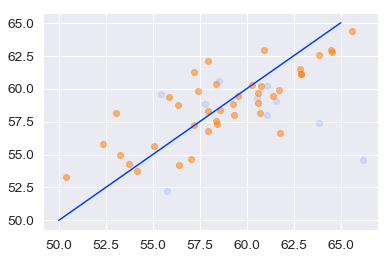

In [1036]:
plt.scatter(test_set_pred_lasso, y_test, alpha = 0.1)
plt.scatter(y_train_val, train_val_set_pred_lasso, alpha = 0.5)
plt.plot(np.linspace(50,65,1000), np.linspace(50,65,1000))

In [1052]:
sns.set(font='sans-serif', font_scale=1.25, palette="bright")

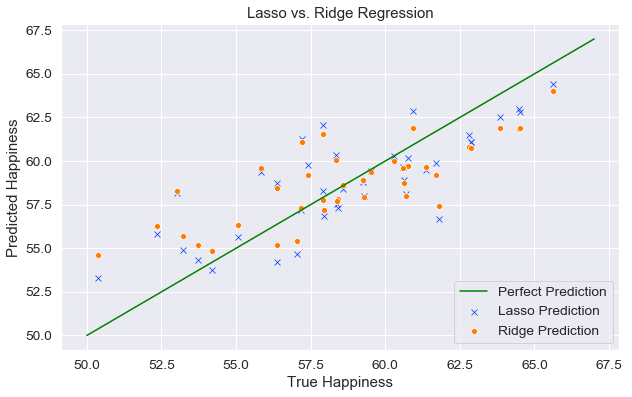

In [1073]:
#Make a pretty seaborn plot:
fig, ax = plt.subplots(figsize=(10,6))
# sns.scatterplot(x=y_test, y=test_set_pred_lasso)
sns.scatterplot(x=y_train_val, y=train_val_set_pred_lasso, marker = 'x')
sns.scatterplot(x=y_train_val, y=train_val_set_pred_ridge)
sns.lineplot(np.linspace(50,67,1000), np.linspace(50,67,1000), color='green')

ax.legend(labels=["Perfect Prediction", "Lasso Prediction", "Ridge Prediction"], loc = 4)
ax.set(xlabel='True Happiness', ylabel='Predicted Happiness', title='Lasso vs. Ridge Regression')
plt.savefig('data/lasso_v_ridge.png', dpi=100)
plt.show()

In [1085]:
# make_resid_plot(y_train_val, train_val_set_pred_lasso)

## Run a RidgeCV Model

In [988]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

# alphavec_r = 10**np.linspace(-2,0,400)
alphavec_r = np.logspace(-2,2,200)
# alpha = 57

ridge_model = RidgeCV(alphas=alphavec_r, cv=4)
ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02]),
    cv=4, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [989]:
# This is the best RIDGE alpha value found
ridge_model.alpha_

5.17092024289676

In [990]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('mean_elevation_bc', 0.9607899528015582),
 ('air_quality', -0.8731839818110476),
 ('pct_area_water_bc', 2.0427932875111066),
 ('HM__x__RF', -1.8233216593260808)]

In [991]:
# Make predictions on the test set using the RIDGE model
test_set_pred_ridge = ridge_model.predict(X_te)
train_val_set_pred_ridge = ridge_model.predict(X_tr)

In [993]:
# Find the MSE and R^2 on the test set using this RIDGE model
# use mean squared error
test_mse = mse(y_test, test_set_pred_ridge)
train_val_mse = mse(y_train_val, train_val_set_pred_ridge)
print('test_rmse: ', np.sqrt(test_mse))
print('train_val_rmse: ', np.sqrt(train_val_mse))
print('total_mse: ', np.sqrt(test_mse)+np.sqrt(train_val_mse))

test_rmse:  4.250230636315564
train_val_rmse:  2.2752288906158955
total_mse:  6.52545952693146


In [994]:
# Find r2 score for RIDGE
r2_ridge = r2_score(y_test, test_set_pred_ridge)
r2_ridge

-1.907559455753546

In [995]:
# THIS IS THE MONEY
r2_ridge_in_sample = r2_score(y_train_val, train_val_set_pred_ridge)
r2_ridge_in_sample

0.5884560401420544

In [996]:
# Find adjusted r2 score for LASSO
adj_r2_ridge = get_adj_r2(r2_ridge, X.shape[0], X.shape[1])
adj_r2_ridge

-2.1660091851538614

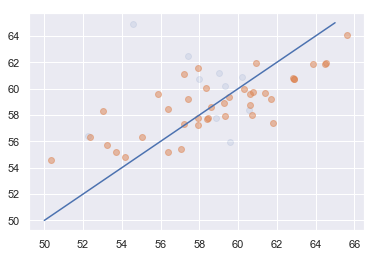

In [997]:
plt.scatter(y_test, test_set_pred_ridge, alpha = 0.1)
plt.scatter(y_train_val, train_val_set_pred_ridge, alpha = 0.5)
plt.plot(np.linspace(50,65,1000), np.linspace(50,65,1000))

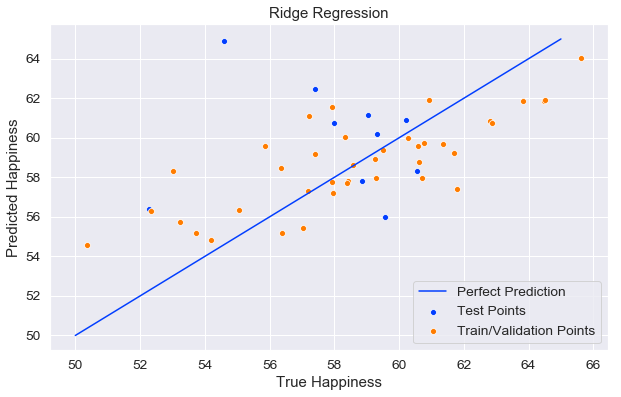

In [1023]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=y_test, y=test_set_pred_ridge)
sns.scatterplot(x=y_train_val, y=train_val_set_pred_ridge)
sns.lineplot(np.linspace(50,65,1000), np.linspace(50,65,1000))

ax.legend(labels=["Perfect Prediction","Test Points","Train/Validation Points"], loc = 4)
ax.set(xlabel='True Happiness', ylabel='Predicted Happiness', title='Ridge Regression')
plt.show()

In [404]:
#Pickle the model
pickle.dump(ridge_model, 'data/model_1')

TypeError: file must have a 'write' attribute

In [1086]:
# make_resid_plot(y_train_val, train_val_set_pred_ridge)

# RidgeCV is being weird. Let's try GridSearch instead

In [1105]:
# Grid Search for Algorithm Tuning

# Use the same list of alphas as I did for RidgeCV (alphavec_r)

# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphavec_r))
grid.fit(X_tr, y_train_val)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-02, 1.04737e-02, ..., 9.54772e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
0.050572131477848004
1.9563983435170649


# OLS in scikit-learn

In [1121]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
ols_model = LinearRegression()
ols_model.fit(X_tr, y_train_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1122]:
list(zip(X_train_val.columns, ols_model.coef_))

[('air_quality', -1.6811498252964447),
 ('rel_humidity', 0.010289521764647683),
 ('avg_num_clear_days', 0.08615124788329383),
 ('pct_area_water', -2.230080993849239),
 ('rainfall_inches', 3.1363886738114766),
 ('temp_f', 2.6356357325831317),
 ('highest_point_ft', -1.3656797723145195),
 ('mean_elevation_ft', 8.442832094214456),
 ('HM__x__RF', -0.6056386024301535),
 ('TM__x__RF', -4.911679411143402),
 ('HP__x__ME', -4.367994069633927),
 ('pct_area_water_bc', 4.936505861421),
 ('mean_elevation_bc', -1.1623781541278733),
 ('hp_bc', 0.4720201742880224)]

In [1123]:
# Make predictions on the test set using the ols model
test_set_pred_ols = ols_model.predict(X_te)
train_val_set_pred_ols = ols_model.predict(X_tr)

In [1124]:
# Find the RMSE and R^2 on the test set using this ols model
test_mse = mse(y_test, test_set_pred_ols)
print('OLS Model test_rmse: ', np.sqrt(test_mse))

OLS Model test_rmse:  3.44805251499422


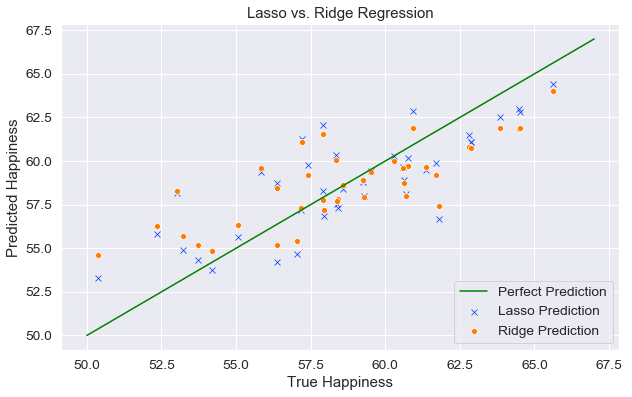

In [1110]:
#Make a pretty seaborn plot:
fig, ax = plt.subplots(figsize=(10,6))
# sns.scatterplot(x=y_test, y=test_set_pred_lasso)
sns.scatterplot(x=y_train_val, y=train_val_set_pred_lasso, marker = 'x')
sns.scatterplot(x=y_train_val, y=train_val_set_pred_ridge)
# sns.scatterplot(x=y_train_val, y=train_val_set_pred_ols, marker = '+')
sns.lineplot(np.linspace(50,67,1000), np.linspace(50,67,1000), color='green')

ax.legend(labels=["Perfect Prediction", "Lasso Prediction", "Ridge Prediction"], loc = 4)
ax.set(xlabel='True Happiness', ylabel='Predicted Happiness', title='Lasso vs. Ridge Regression')
plt.savefig('data/lasso_v_ridge.png', dpi=100)
plt.show()

TypeError: probplot() got an unexpected keyword argument 'marker'

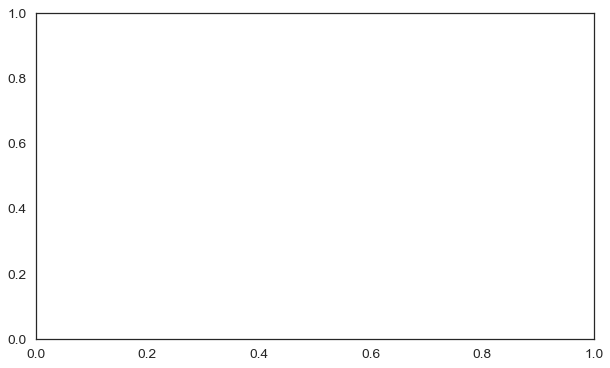

In [1104]:
# resid_lasso = y_train_val - train_val_set_pred_lasso
# resid_ridge = y_train_val - train_val_set_pred_ridge
# resid_ols = y_train_val - train_val_set_pred_ols

# with sns.axes_style('white'):
#         fig, ax = plt.subplots(figsize=(10,6))
#         stats.probplot(resid_ols, dist="norm", plot=plt, marker='x')
#         stats.probplot(resid_lasso, dist="norm", plot=plt)
#         stats.probplot(resid_ridge, dist="norm", plot=plt)
#         plt.title("Normal Q-Q plot")
#         plt.show() 